<a href="https://colab.research.google.com/github/tlqwkrk4471/PytorchBasic/blob/main/Implementing_ViT_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00


# Implementing ViT in Pytorch
Reference: https://github.com/FrancescoSaverioZuppichini/ViT

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

## Data

In [3]:
#img = Image.open('./meat_data/KakaoTalk_Image_2023-06-13-18-11-22_001.jpeg')

#fig = plt.figure()
#plt.imshow(img)

In [4]:
#img.size

In [5]:
#transform = Compose([Resize((4016, 4016)), ToTensor()])
#x = transform(img)
#x = x.unsqueeze(0)
#x.shape

In [6]:
from torch.utils.data import DataLoader

import torchvision.datasets as dset

if torch.cuda.is_available() :
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

transform = Compose([ToTensor()])
train_data = dset.CIFAR10('./datasets', train = True, download = True, transform = transform)
loader_train = DataLoader(train_data, batch_size = 32, shuffle= True)

test_data = dset.CIFAR10('./datasets', train = False, download = True, transform = transform)
loader_test = DataLoader(test_data, batch_size = 32, shuffle = True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29854778.78it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


In [7]:
x = train_data[0][0].unsqueeze(0)
x.shape

torch.Size([1, 3, 32, 32])

## Patches Embedding

2D image → sequence of flattened 2D patches

H x W x C → N x (PPC)

In [8]:
patch_size = 4
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
patches.shape

torch.Size([1, 64, 48])

In [9]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3, patch_size: int = 4, emb_size: int = 48):
    self.patch_size = patch_size
    super().__init__()
    self.projection = nn.Sequential(
      Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
      nn.Linear(patch_size * patch_size * in_channels, emb_size)
    )

  def forward(self, x: Tensor) -> Tensor:
    x = self.projection(x)
    return x

In [10]:
PatchEmbedding()(x).shape

torch.Size([1, 64, 48])

In [11]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3, patch_size: int = 4, emb_size: int = 48):
    self.patch_size = patch_size
    super().__init__()
    self.projection = nn.Sequential(
        nn.Conv2d(in_channels, emb_size, kernel_size = patch_size, stride = patch_size),
        # out_channels = emb_size(768)

        Rearrange('b e h w -> b (h w) e')
        # in_e = channel
        # out_e = emb_size
    )

  def forward(self, x: Tensor) -> Tensor:
    x = self.projection(x)
    return x

PatchEmbedding()(x).shape
# torch.Size([1, 3, 4016, 4016]) -> torch.Size([1, 63001, 768])

torch.Size([1, 64, 48])

## CLS Token
shape = (1,1,emb_size)

In [12]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3, patch_size: int = 4, emb_size: int = 48):
    self.patch_size = patch_size
    super().__init__()
    self.projection = nn.Sequential(
        nn.Conv2d(in_channels, emb_size, kernel_size = patch_size, stride = patch_size),
        Rearrange('b e h w -> b (h w) e')
    )

    self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))

  def forward(self, x: Tensor) -> Tensor:
    b, _, _, _ = x.shape
    x = self.projection(x)
    cls_token = repeat(self.cls_token, '() n e -> b n e', b = b)

    x = torch.cat([cls_token, x], dim = 1)
    return x

PatchEmbedding()(x).shape

torch.Size([1, 65, 48])

## Position Embedding
shape = (n+1, emb_size)

batch size는 broadcasting으로 같은 Position Embdding 적용하기 때문에 명시하지 않음

Position Embedding은 trainable하기 때문에 Parameter로 설정

In [13]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3, patch_size: int = 4, emb_size: int = 48, img_size: int = 32):
    self.patch_size = patch_size
    super().__init__()
    self.projection = nn.Sequential(
      nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
      Rearrange('b e (h) (w) -> b (h w) e'),
    )
    self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
    self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))

  def forward(self, x: Tensor) -> Tensor:
    b, _, _, _ = x.shape
    x = self.projection(x)
    cls_tokens = repeat(self.cls_token, '() n e -> b n e', b = b)

    x = torch.cat([cls_tokens, x], dim = 1)

    x += self.positions
    return x

PatchEmbedding()(x).shape

torch.Size([1, 65, 48])

# Transformer Encoder
## Multi-Head Attention

In [14]:
class MultiHeadAttention(nn.Module):
  def __init__(self, emb_size: int = 48, num_heads: int = 8, dropout: float = 0):
    super().__init__()
    self.emb_size = emb_size
    self.num_heads = num_heads
    self.keys = nn.Linear(emb_size, emb_size)
    self.queries = nn.Linear(emb_size, emb_size)
    self.values = nn.Linear(emb_size, emb_size)
    self.att_drop = nn.Dropout(dropout)
    self.projection = nn.Linear(emb_size, emb_size)
    self.scaling = (self.emb_size // num_heads) ** -0.5

  def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
    queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
    keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
    values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)

    energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
    if mask is not None:
      fill_value = torch.finfo(torch.float32).min
      energy.mask_fill(~mask, fill_value)

    att = F.softmax(energy, dim=-1) * self.scaling
    att = self.att_drop(att)

    out = torch.einsum('bhal, bhlv -> bhav ', att, values)
    out = rearrange(out, "b h n d -> b n (h d)")
    out = self.projection(out)
    return out

patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 65, 48])

In [15]:
class MultiHeadAttention(nn.Module):
  def __init__(self, emb_size: int = 48, num_heads: int = 8, dropout: float = 0):
    super().__init__()
    self.emb_size = emb_size
    self.num_heads = num_heads
    # fuse the queries, keys and values in one matrix
    self.qkv = nn.Linear(emb_size, emb_size * 3)
    self.att_drop = nn.Dropout(dropout)
    self.projection = nn.Linear(emb_size, emb_size)

  def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
    # split keys, queries and values in num_heads
    qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
    queries, keys, values = qkv[0], qkv[1], qkv[2]
    # sum up over the last axis
    energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
    if mask is not None:
      fill_value = torch.finfo(torch.float32).min
      energy.mask_fill(~mask, fill_value)

    scaling = self.emb_size ** (1/2)
    att = F.softmax(energy, dim=-1) / scaling
    att = self.att_drop(att)
    # sum up over the third axis
    out = torch.einsum('bhal, bhlv -> bhav ', att, values)
    out = rearrange(out, "b h n d -> b n (h d)")
    out = self.projection(out)
    return out

patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 65, 48])

## Residuals

In [16]:
class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, **kwargs):
    res = x
    x = self.fn(x, **kwargs)
    x += res
    return x

In [17]:
class FeedForwardBlock(nn.Sequential):
  def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
    super().__init__(
      nn.Linear(emb_size, expansion * emb_size),
      nn.GELU(),
      nn.Dropout(drop_p),
      nn.Linear(expansion * emb_size, emb_size),
    )

In [21]:
class TransformerEncoderBlock(nn.Sequential):
  def __init__(self,
      emb_size: int = 48,
      drop_p: float = 0.,
      forward_expansion: int = 4,
      forward_drop_p: float = 0.,
      ** kwargs):
    super().__init__(
      ResidualAdd(nn.Sequential(
        nn.LayerNorm(emb_size),
        MultiHeadAttention(emb_size, **kwargs),
        nn.Dropout(drop_p)
      )),
      ResidualAdd(nn.Sequential(
        nn.LayerNorm(emb_size),
        FeedForwardBlock(
          emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
        nn.Dropout(drop_p)
      )
    ))

In [22]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 65, 48])

In [23]:
class TransformerEncoder(nn.Sequential):
  def __init__(self, depth: int = 12, **kwargs):
    super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [24]:
class ClassificationHead(nn.Sequential):
  def __init__(self, emb_size: int = 48, n_classes: int = 10):
    super().__init__(
      Reduce('b n e -> b e', reduction='mean'),
      nn.LayerNorm(emb_size),
      nn.Linear(emb_size, n_classes))

In [26]:
class ViT(nn.Sequential):
  def __init__(self,
      in_channels: int = 3,
      patch_size: int = 16,
      emb_size: int = 48,
      img_size: int = 32,
      depth: int = 12,
      n_classes: int = 10,
      **kwargs):
    super().__init__(
      PatchEmbedding(in_channels, patch_size, emb_size, img_size),
      TransformerEncoder(depth, emb_size=emb_size, **kwargs),
      ClassificationHead(emb_size, n_classes)
    )

In [28]:
summary(ViT(), (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 48, 2, 2]          36,912
         Rearrange-2                [-1, 4, 48]               0
    PatchEmbedding-3                [-1, 5, 48]               0
         LayerNorm-4                [-1, 5, 48]              96
            Linear-5               [-1, 5, 144]           7,056
           Dropout-6              [-1, 8, 5, 5]               0
            Linear-7                [-1, 5, 48]           2,352
MultiHeadAttention-8                [-1, 5, 48]               0
           Dropout-9                [-1, 5, 48]               0
      ResidualAdd-10                [-1, 5, 48]               0
        LayerNorm-11                [-1, 5, 48]              96
           Linear-12               [-1, 5, 192]           9,408
             GELU-13               [-1, 5, 192]               0
          Dropout-14               [-1,

In [30]:
learning_rate = 1e-3

vit = ViT()
optimizer = torch.optim.Adam(vit.parameters(), lr = learning_rate, betas = (0.9, 0.99))

In [35]:
def check_accuracy(data_loader, model, verbose = True) :

  if verbose :
    if data_loader.dataset.train :
      print('Train set accurcy')
    else :
      print('Test set accuracy')

  num_correct = 0
  num_total = 0
  model.eval() # evaluation mode

  with torch.no_grad() :
    for x, y in data_loader :
      x = x.to(device = device)
      y = y.to(device = device)

      scores = model(x)

      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_total += preds.size(0)

    acc = float(num_correct) / num_total
    if verbose :
      print('Correct : (%d / %d), Accuracy : (%.2f)' % (num_correct, num_total, 100*acc))

  return 100*acc

In [36]:
def train(model, optimizer, data_loader, epochs = 1, verbose = True):
  model = model.to(device = device)

  log = {'loss' : [], 'acc' : []}

  for e in range(epochs):
    if verbose :
      print('epochs : %d / %d' % (e, epochs))
    log['acc'].append(check_accuracy(loader_test, model, verbose = verbose))

    for t, (x, y) in enumerate(data_loader) :
      model.train() # training mode
      x = x.to(device = device)
      y = y.to(device = device)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if t % 100 == 0 :
        log['loss'].append(loss)
        if verbose :
          print('iteration %d, loss = %.4f' % (t, loss.item()))

  return log

In [42]:
training_log = train(vit, optimizer, loader_train, epochs = 10, verbose = False)

In [43]:
def plot_loss(loss, label) :
  plt.xlabel('iterations(1e2)')
  plt.ylabel('training loss')

  plt.plot(loss, label = label)
  plt.legend()

def plot_acc(acc, label) :
  plt.xlabel('epochs')
  plt.ylabel('accuracy(test data)')

  plt.plot(acc, label = label)
  plt.legend()

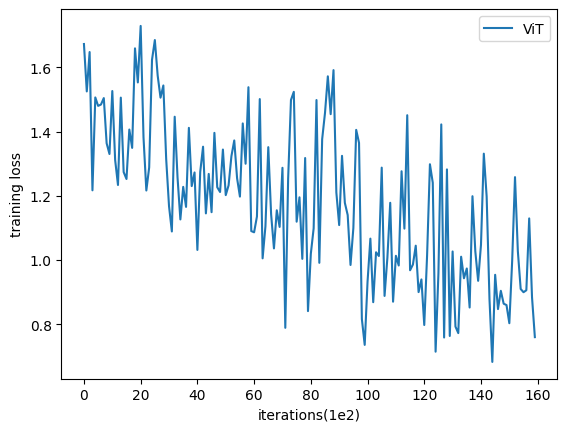

In [44]:
loss_values = torch.tensor(training_log['loss']).cpu().numpy()
plot_loss(loss_values, 'ViT')

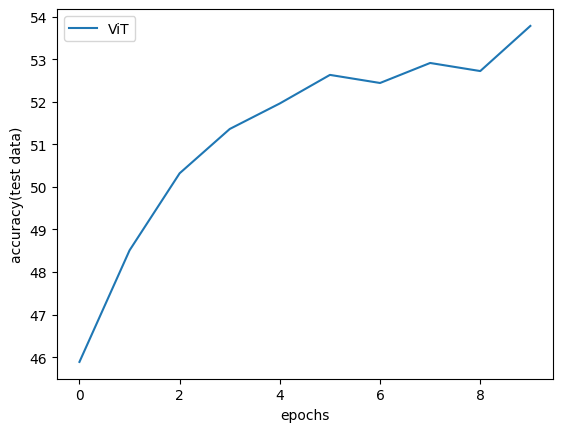

In [45]:
plot_acc(training_log['acc'], 'ViT')